## DSCI 100 Project Proposal Team 44

# Project Title: Determining The Best Predictors Heart Disease

## Introduction

Heart disease or failure is a condition where the heart muscle of the afflicted cannot pump blood as efficiently due to a structural defect, compared to a person without the condition. Quick diagnosis and implementation of treatments may be able to drastically improve someone's chances of living through heart disease.

The question we will be trying to answer with our project is the following: 
Which attributes are the best and worst for predicting heart disease? What attributes are relevant?

In this project, we hope to accomplish the following three things:
1. Make a training model that can accurately predict whether a person has a heart disease given certain classifiers and what stage of heart disease they have.
2. Determine the correlation of heart disease with the 13 classifiers excluding num. (See Appendix) 
3. Compare the accuracy of models trained under specific classifiers by testing the result of the predictions against the clinical data.

We will be using the processed Cleveland data provided by the UCI Machine Learning Repository. The main attributes we will be looking into include the ones numbered 1-14 as seen on the listed attributes on the website. Initially, there were 6 observations that contained missing information that we decided to remove from the overall data set we decided to use. All columns of the data set contain quantitative data with certain values corresponding to a meaning. 


## Methods & Results

In [73]:
#install.packages("corrplot")

In [74]:
#Loading relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
#library(corrplot)

In [75]:
set.seed(800)

#Read data in from UCI website
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                 col_names = FALSE )

#Add column names
attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

#Remove NA values and reformat data types to correct type
data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))

#Remove categorial predictors 
data <-  data %>% 
    select(-c(cp, fbs, restecg, exang, slope, thal))

#Convert the prediction label into a factor
data <- data %>%
  mutate(num = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(num = as_factor(num)) %>% 
  mutate(sex = ifelse(sex == 1 ,"male","female"))

head(data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,trestbps,chol,thalach,oldpeak,ca,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,male,145,233,150,2.3,0,healthy
67,male,160,286,108,1.5,3,disease
67,male,120,229,129,2.6,2,disease
37,male,130,250,187,3.5,0,healthy
41,female,130,204,172,1.4,0,healthy
56,male,120,236,178,0.8,0,healthy


In [76]:
set.seed(800)

heart_split <- initial_split(data, prop = 0.8, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)   

head(heart_train)


age,sex,trestbps,chol,thalach,oldpeak,ca,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,male,160,286,108,1.5,3,disease
37,male,130,250,187,3.5,0,healthy
41,female,130,204,172,1.4,0,healthy
56,male,120,236,178,0.8,0,healthy
62,female,140,268,160,3.6,2,disease
57,female,120,354,163,0.6,0,healthy


### Exploratory Data Analysis

In [77]:
set.seed(800)

# Exploratory Tables ------------------------------------------------------
heart_proportions <- heart_train %>% 
  group_by(num) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train))%>%
  rename("disease" = num,
         "count" = n)
heart_proportions

summary <- heart_train %>%
  select(-c(num,sex)) %>% 
  pivot_longer(everything()) %>%
  arrange(name) %>%
  group_by(name) %>%
  summarize(
    mean = mean(value),
    std_dev = sd(value),
    median = median(value),
    max = max(value),
    min = min(value),
    quartile.1 = quantile(value, 0.25),
    quartile.3 = quantile(value, 0.75)) %>%
  rename("predictor" = name)
summary


num_char <- heart_train %>% 
  select(num, sex, age) %>% 
  group_by(num, sex) %>% 
  summarise(n = n())
num_char


`summarise()` ungrouping output (override with `.groups` argument)



disease,count,percent
<fct>,<int>,<dbl>
healthy,129,53.9749
disease,110,46.0251


`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,std_dev,median,max,min,quartile.1,quartile.3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,54.5774059,9.2487378,56.0,77.0,29,47.0,61.0
ca,0.6987448,0.9577407,0.0,3.0,0,0.0,1.0
chol,249.3430962,53.4072614,244.0,564.0,126,211.5,279.5
oldpeak,1.0602510,1.1954613,0.8,6.2,0,0.0,1.6
thalach,150.0502092,23.0077990,153.0,202.0,71,138.0,165.0
trestbps,132.2217573,17.2150568,130.0,200.0,94,120.0,140.0


`summarise()` regrouping output by 'num' (override with `.groups` argument)



num,sex,n
<fct>,<chr>,<int>
healthy,female,52
healthy,male,77
disease,female,20
disease,male,90


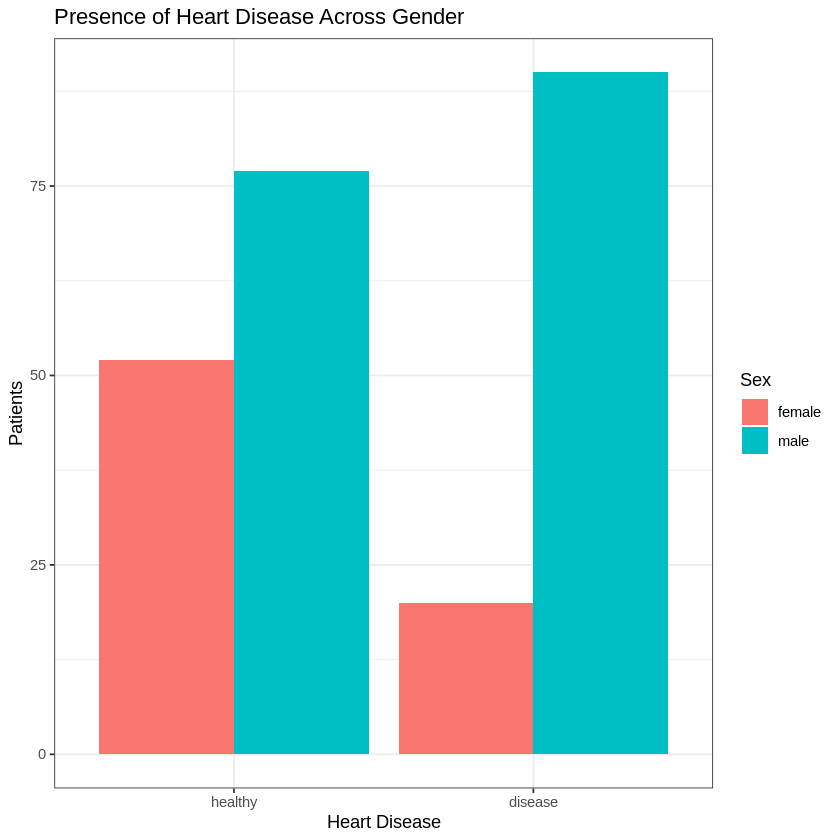

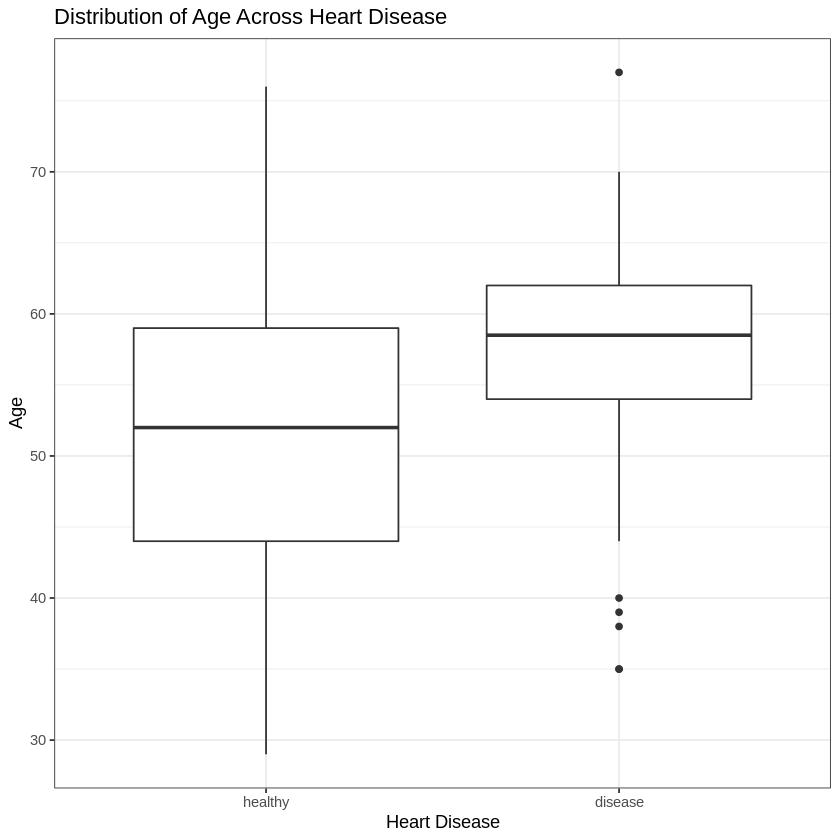

In [78]:
# Visualizations ----------------------------------------------------------

#Grouped barchart for sex vs heart disease
sex_bar_plot <- num_char %>% 
  ggplot(aes(x = num, y = n, fill = sex))+
  geom_bar(position="dodge", stat="identity")+
  labs(x = "Heart Disease", y = "Patients", fill = "Sex")+
  theme_bw()+
  ggtitle("Presence of Heart Disease Across Gender")
sex_bar_plot

#age box plot
age_box_plot <- heart_train %>% 
  ggplot(aes(x= as.factor(num), y = age))+
  geom_boxplot()+
  labs(x = "Heart Disease", y = "Age")+
  theme_bw()+
  ggtitle("Distribution of Age Across Heart Disease")
age_box_plot

### Data Exploration Summary 

Based on the exploratory data analysis performed above: 
 - There seems to be a sex bias, where there is a higher incidence rate of heart disease in men. Stratifying by sex could produce more accurate classifier since men and woman dont' appear to be affected the same
 - The dataset contains simular numbers of those with heartdisease and without
 - The median age of those with heart disease is greater than healthy individuals. Is possible that the classifier will be more accurate for predicting disease status for those aged 45-65, as the majority of indiviudals with heart disease fall in this age range


### Knn Classification

#### Determination of the most optimal value of K

In [79]:
set.seed(800)

#create the model recipe
recipe <- recipe(num ~ age + trestbps + chol + thalach + oldpeak + ca,
                         data = heart_train) %>% 
  step_scale(all_predictors()) %>% 
  step_center(all_predictors())

#Create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

#Cross-validation
heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

#Combine above steps into a single workflow
knn_results <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec) %>% 
  tune_grid(resamples = heart_vfold, grid = 10) %>% 
  collect_metrics() 

accuracies <- knn_results %>% 
  filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6828901,5,0.05792994,Model1
4,accuracy,binary,0.7242908,5,0.03757312,Model2
5,accuracy,binary,0.7617908,5,0.01980029,Model3
7,accuracy,binary,0.7577128,5,0.02710237,Model4
9,accuracy,binary,0.7535461,5,0.02996959,Model5
10,accuracy,binary,0.7535461,5,0.02996959,Model6
12,accuracy,binary,0.7451241,5,0.02997155,Model7
13,accuracy,binary,0.7494681,5,0.03438482,Model8
14,accuracy,binary,0.7494681,5,0.03438482,Model9


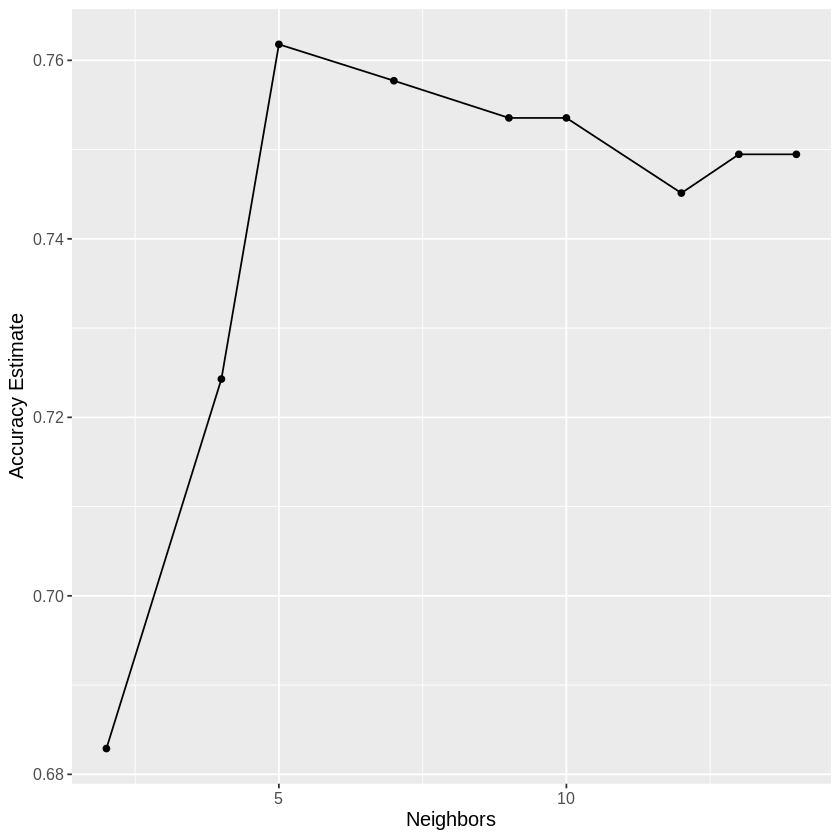

In [80]:
#Plot the estimated model accuracy vs number of neighbors
accuracy_vs_n <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_n

In [81]:
set.seed(800)

knn_spec_rt <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_rt <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_rt) %>% 
  fit(data = heart_train)

heart_train_predictions <- predict(knn_fit_rt, heart_train) %>% 
  bind_cols(heart_train)

heart_metrics_train <- heart_train_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_train

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8242678


#### Predict Model Accuracy on Testing Data

In [82]:
set.seed(800)
heart_test_predictions <- predict(knn_fit_rt, heart_test) %>% 
  bind_cols(heart_test)

heart_metrics_test <- heart_test_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7931034


In [83]:
#Confusion matrix 

confusion <- heart_test_predictions %>% 
             conf_mat(truth = num , estimate = .pred_class)

confusion

          Truth
Prediction healthy disease
   healthy      24       5
   disease       7      22

### Forward Selection
#### Compare the selected predictors to what forward selection sugggest are the optimal predictors

In [84]:
set.seed(800)

#Predictor columns
names <- colnames(heart_train %>% select(-c(num, sex)))

#Tibble to store accuracies:
accuracies_fs <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

#create a model spec
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>%
  set_engine("kknn") %>% 
  set_mode("classification")

#Create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

#Store the total number of predictors 
n_total <- length(names)

#Store selected predictors
selected <- c()


In [85]:
set.seed(800)
for (i in 1:n_total) {
  accs <- list()
  models <- list()
  for (j in 1:length(names)){
    preds_new <- c(selected, names[[j]])
    model_string <- paste("num", "~", paste(preds_new, collapse = '+'))
    
    #Create recipe from model string
    heart_recipe <- recipe(as.formula(model_string),
                            data = heart_train) %>% 
      step_scale(all_predictors()) %>% 
      step_center(all_predictors())
    
    #Tune KNN classifier with these predictors
    #collect accuracy for best k
    
    acc <- workflow() %>% 
      add_recipe(heart_recipe) %>% 
      add_model(knn_spec) %>% 
      tune_grid(resamples = heart_vfold, grid = 10) %>% 
      collect_metrics() %>% 
      filter(.metric == "accuracy") %>% 
      summarise(mx = max(mean))
    acc <- acc$mx %>% unlist()
    
    #add result to dataframe
    accs[[j]] <- acc
    models[[j]] <- model_string
  }
  jstar <- which.max(unlist(accs))
  accuracies_fs <- accuracies_fs %>% 
    add_row(size = i, 
            model_string = models[[jstar]], 
            accuracy = accs[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

In [86]:
#View the estimated model accuracy for each combination of predictors
accuracies_fs

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ ca,0.7403369
2,num ~ ca+oldpeak,0.7487589
3,num ~ ca+oldpeak+chol,0.7737589
4,num ~ ca+oldpeak+chol+age,0.7614362
5,num ~ ca+oldpeak+chol+age+thalach,0.7696809
6,num ~ ca+oldpeak+chol+age+thalach+trestbps,0.7990248


#### Comparing Model Accuracy Across Sex

In [87]:
set.seed(800)
#Create subsets of the wrangled dataset to stratefy by gender
female_data <- data %>% 
    filter(sex == "female") %>% 
    select(-sex)

male_data <- data %>% 
    filter(sex == "male") %>% 
    select(-sex)

# head(female_data)
# head(male_data)

#Creating training data sets for female and male data
f_heart_split <- initial_split(female_data, prop = 0.8, strata = num)
f_heart_train <- training(f_heart_split)
f_heart_test <- testing(f_heart_split)  

m_heart_split <- initial_split(male_data, prop = 0.8, strata = num)
m_heart_train <- training(m_heart_split)
m_heart_test <- testing(m_heart_split)  

### Female subset

In [88]:
set.seed(800)
#create the model recipe
recipe <- recipe(num ~ age + trestbps + chol + thalach + oldpeak + ca,
                         data = f_heart_train) %>% 
  step_scale(all_predictors()) %>% 
  step_center(all_predictors())

#Create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

#Cross-validation
heart_vfold <- vfold_cv(f_heart_train,
                        v = 5,
                        strata = num)

#Combine above steps into a single workflow
knn_results <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec) %>% 
  tune_grid(resamples = heart_vfold, grid = 10) %>% 
  collect_metrics() 

accuracies_female <- knn_results %>% 
  filter(.metric == "accuracy")
accuracies_female

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6379412,5,0.04859117,Model1
3,accuracy,binary,0.6519118,5,0.05502876,Model2
4,accuracy,binary,0.6519118,5,0.05502876,Model3
5,accuracy,binary,0.7530392,5,0.04192377,Model4
7,accuracy,binary,0.7663725,5,0.03687226,Model5
9,accuracy,binary,0.7797059,5,0.02954040,Model6
10,accuracy,binary,0.7797059,5,0.02954040,Model7
12,accuracy,binary,0.7679412,5,0.02744555,Model8
15,accuracy,binary,0.7812745,5,0.02646351,Model9


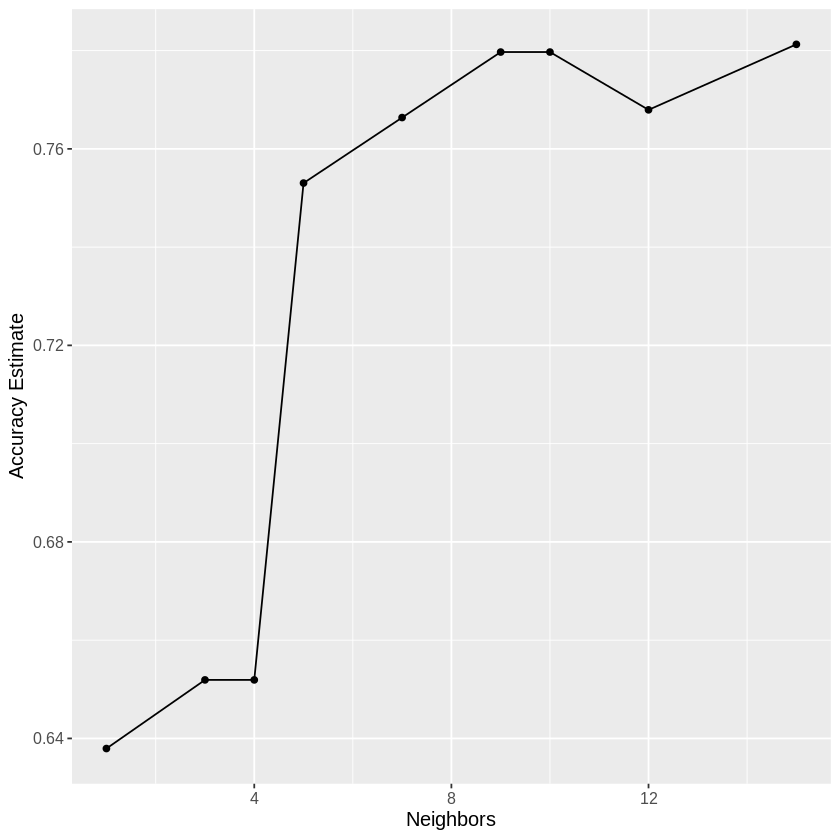

In [89]:
accuracy_vs_n <- ggplot(accuracies_female, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_n

In [94]:
set.seed(800)

knn_spec_rt_female <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_rt_female <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_rt_female) %>% 
  fit(data = f_heart_train)

heart_train_predictions_f <- predict(knn_fit_rt_female, f_heart_train) %>% 
  bind_cols(f_heart_train)

heart_metrics_train_f <- heart_train_predictions_f %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_train_f

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7820513


### Male Subset

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7401515,5,0.02961700,Model1
3,accuracy,binary,0.7590909,5,0.02715773,Model2
5,accuracy,binary,0.7649621,5,0.02622337,Model3
8,accuracy,binary,0.7837121,5,0.01467528,Model4
9,accuracy,binary,0.7835227,5,0.01817738,Model5
12,accuracy,binary,0.7649621,5,0.02404893,Model6
13,accuracy,binary,0.7401515,5,0.02791971,Model7
15,accuracy,binary,0.7526515,5,0.02463104,Model8


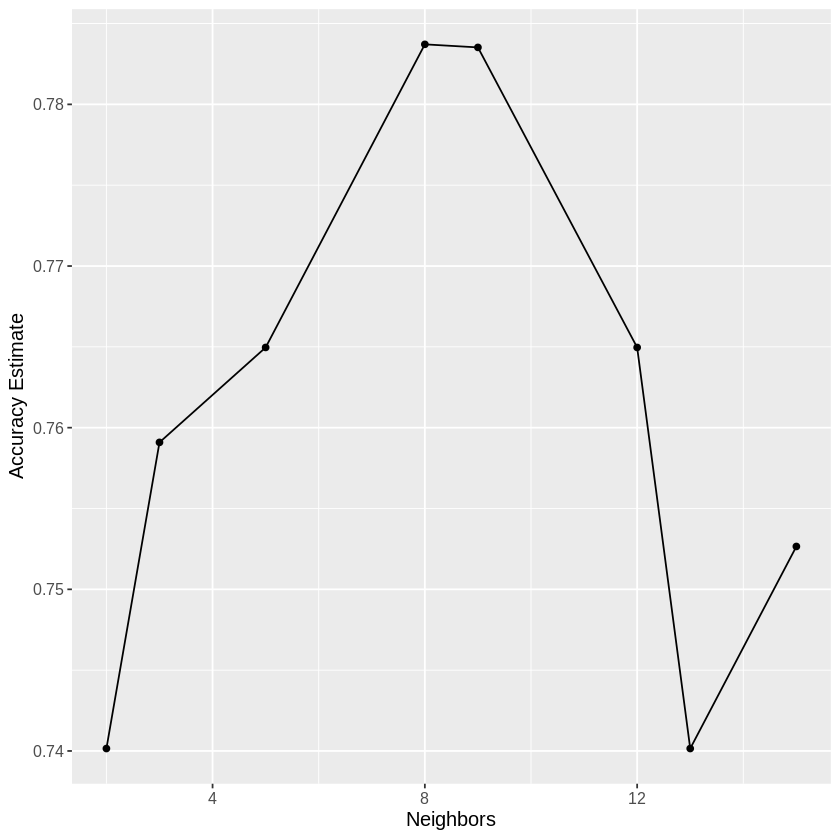

In [91]:
set.seed(800)
#create the model recipe
recipe <- recipe(num ~ age + trestbps + chol + thalach + oldpeak + ca,
                         data = m_heart_train) %>% 
  step_scale(all_predictors()) %>% 
  step_center(all_predictors())

#Create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

#Cross-validation
heart_vfold <- vfold_cv(m_heart_train,
                        v = 5,
                        strata = num)

#Combine above steps into a single workflow
knn_results <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec) %>% 
  tune_grid(resamples = heart_vfold, grid = 10) %>% 
  collect_metrics() 

accuracies_male <- knn_results %>% 
  filter(.metric == "accuracy")
accuracies_male

accuracy_vs_n <- ggplot(accuracies_male, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_n

In [92]:
set.seed(800)

knn_spec_rt_male <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_rt_male <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_rt_male) %>% 
  fit(data = m_heart_train)

heart_train_predictions_m <- predict(knn_fit_rt_male, m_heart_train) %>% 
  bind_cols(m_heart_train)

heart_metrics_train_m <- heart_train_predictions_m %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_train_m

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8333333


#### Predict Heart Disease in female and male testing data

## Methods
All of the variables will be considered to determine which of the predictors are best suited for predicting heart disease and which ones are irrelevant and negatively affect accuracy. We will be using the forward selection method of choosing the best predictors due to better processing time over the best-subset selection method. 

We will be visualizing the data as follows:

1. To find the ideal k value we will use a line+point graph that plots neighbors vs estimated accuracies to identify what k value yields the most accurate results.
2. To find the best number of predictors, we will plot an estimated accuracy vs. number of predictors line and point graph
3. To visualize model accuracy, we will plot a bar graph that displays the number of false-positive, true positive, false negative, and true negative results.



## Expected Outome and Significance

### Expectations
We expect to find that not all of the original predictors are required to create the most accurate classifier.  As shown through the correlation matrix and accompanying plot, some attributes do not appear to have a strong correlation with heart disease. 

### Implications
The findings could help practitioners diagnose heart disease more accurately, by only considering relevant predictor metrics. This classifier could also be used to perform a preliminary screen on who is likely to have heart disease and require a more extensive follow-up for an official diagnosis. By identifying what metrics are relevant to the prognosis of heart disease, these could be tracked to monitor patient progression.

### Future Questions 
Since only the Cleveland dataset was used to train the classifier, there could be a geographical bias. A future direction could be to analyze the accuracy of the classifier for other areas and datasets.  

## References

Heart Disease Data Set. (1988, July 1). UCI Machine Learning Repository. Retrieved   March 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

NHS. (n.d.). NHS choices. Retrieved March 5, 2022, from https://www.nhs.uk/conditions/coronary-heart-disease/

## Appendix

| Attribute      | Description |
| ----------- | ----------- |
| age         | age       |
| sex         | sex         |
| cp          | chest pain |
| trestbps    | resting blood pressure |
| chol        | cholesterol |
| fbs         | fasting blood sugar |
| restecg     | resting electrocardiographic results |
| thalach     | maximum heart rate record |
| exang       | exercise induced angia |
| oldpeak     | ST depression indiced by exercise relative to rest |
| slope       | slope of peak exercise ST segment |
| ca          | number of major vessels coloured by fluoroscopy |
| thal        | thalassemia |
| num         | predicted attribute |



